In [15]:
import numpy as np
import pandas as pd
import xarray as xr
import datetime
from pycontrails.datalib.ecmwf import ERA5
from pycontrails.models.emissions import Emissions
from pycontrails.core.met import MetDataArray, MetDataset
from pycontrails.physics import units
from pycontrails.core.met_var import (
    AirTemperature,
    SpecificHumidity,
)
from init_chem import ChemDataset
from boxm import BoxModel

In [16]:
# Initialise coord arrays
lon_bounds = (0, 80) #np.arange(-180, 180, 5)
lat_bounds = (0, 20) #np.arange(-90, 90, 5)
alt_bounds = (8000, 12000)
horiz_res = 0.5
vert_res = 500
met_pressure_levels = np.array([400, 300, 200, 100])

time = ("2022-01-01 00:00:00", "2022-01-01 08:00:00")
ts_met = "1H"
ts_disp = "1min"
ts_chem = "5min"

runtime = "24H"

lons = np.arange(lon_bounds[0], lon_bounds[1], horiz_res)
lats = np.arange(lat_bounds[0], lat_bounds[1], horiz_res)
alts = np.arange(alt_bounds[0], alt_bounds[1], vert_res)

In [17]:
# Import met data from ERA5
era5 = ERA5(
        time=time,
        timestep_freq=ts_met,
        variables=[
                "t",
                "q",
                "u",
                "v",
                "w",
                "z",
                "relative_humidity"
        ],
        pressure_levels=met_pressure_levels
)

In [18]:
# download data from ERA5 (or open from cache)
met = era5.open_metdataset()
met.data = met.data.transpose("latitude", "longitude", "level", "time", ...)

met.data = met.data.interp(longitude=lons, latitude=lats, level=units.m_to_pl(alts), method="linear")

cartopy.mpl.geocollection.GeoQuadMesh

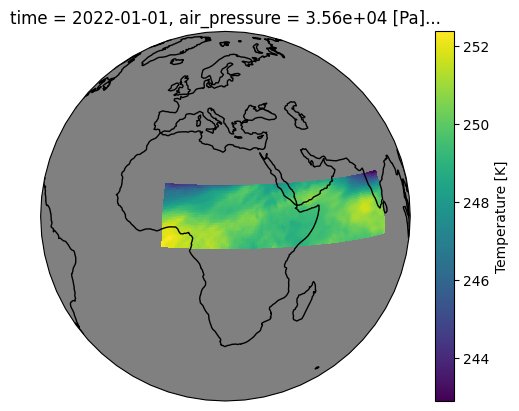

In [19]:
import cartopy.crs as ccrs

p = met.data["air_temperature"].isel(level=0, time=0).plot(
    subplot_kws=dict(projection=ccrs.Orthographic(20, 10), facecolor="gray"),
    transform=ccrs.PlateCarree(),
)

p.axes.set_global()

p.axes.coastlines()

# save figure
p.figure.savefig(str(lon_bounds) + str(lat_bounds) + ".png")

type(p)

In [20]:
# initialise example chem MetDataset
chem = ChemDataset(
        lon_bounds=lon_bounds,
        lat_bounds=lat_bounds,
        met=met,
        time=time,
) #.init_chem()
#chem.data = chem.data.transpose("latitude", "longitude", "level", "time", ...)

In [21]:
chem.open_chemdataset()

ValueError: coordinate latitude has dimensions ('latitude',), but these are not a subset of the DataArray dimensions ()

In [22]:
chem

ChemDataset with data:

<xarray.Dataset>
Dimensions:        (latitude: 4, longitude: 16, time: 9, photol_params: 34,
                    level: 9, photol_coeffs: 96, therm_coeffs: 510, species: 243)
Coordinates:
  * latitude       (latitude) float64 0.0 5.0 10.0 15.0
  * longitude      (longitude) float64 0.0 5.0 10.0 15.0 ... 60.0 65.0 70.0 75.0
  * level          (level) float64 962.0 861.0 759.0 658.0 ... 353.0 251.0 150.5
  * time           (time) datetime64[ns] 2022-01-01 ... 2022-01-01T08:00:00
  * photol_params  (photol_params) float64 1.0 2.0 3.0 4.0 ... 55.0 56.0 57.0
  * photol_coeffs  (photol_coeffs) int64 1 2 3 4 5 6 7 ... 90 91 92 93 94 95 96
  * therm_coeffs   (therm_coeffs) int64 1 2 3 4 5 6 ... 505 506 507 508 509 510
  * species        (species) <U10 'ANHY' 'APINENE' ... 'UDCARB14' 'UDCARB8'
Data variables:
    local_time     (latitude, longitude, time) float64 dask.array<chunksize=(4, 16, 1), meta=np.ndarray>
    sza            (latitude, longitude, time) float64 dask.array<chunksize=(4, 16, 1), meta=np.ndarray>
    J              (latitude, longitude, time, photol_params) float64 dask.array<chunksize=(4, 16, 1, 34), meta=np.ndarray>
    DJ             (latitude, longitude, level, time, photol_coeffs) float64 dask.array<chunksize=(4, 16, 9, 1, 96), meta=np.ndarray>
    RC             (latitude, longitude, level, time, therm_coeffs) float64 dask.array<chunksize=(4, 16, 9, 1, 510), meta=np.ndarray>
    soa            (latitude, longitude, level, time) float64 dask.array<chunksize=(4, 16, 9, 1), meta=np.ndarray>
    mom            (latitude, longitude, level, time) float64 dask.array<chunksize=(4, 16, 9, 1), meta=np.ndarray>
    Y              (latitude, longitude, level, time, species) float64 dask.array<chunksize=(4, 16, 9, 1, 243), meta=np.ndarray>
    EM             (latitude, longitude, level, time, species) float64 dask.array<chunksize=(4, 16, 9, 1, 243), meta=np.ndarray>
    FL             (latitude, longitude, level, time, species) float64 dask.array<chunksize=(4, 16, 9, 1, 243), meta=np.ndarray>

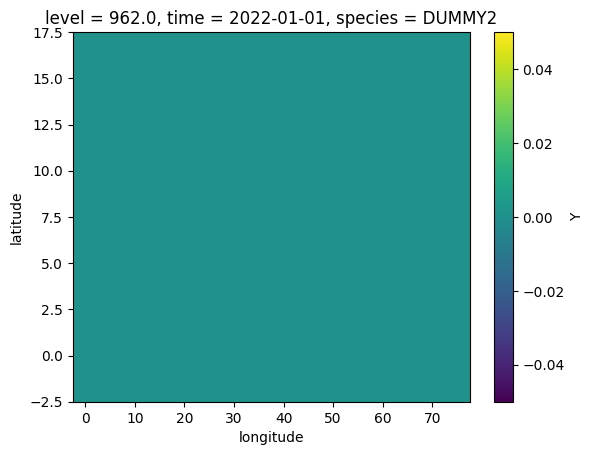

In [23]:
chem.data["Y"].sel(species="DUMMY2", time=time[0], level=962).plot()

In [24]:
chem.data["local_time"]

<xarray.DataArray 'local_time' (latitude: 4, longitude: 16, time: 9)>
dask.array<xarray-local_time, shape=(4, 16, 9), dtype=float64, chunksize=(4, 16, 1), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 0.0 5.0 10.0 15.0
  * longitude  (longitude) float64 0.0 5.0 10.0 15.0 ... 60.0 65.0 70.0 75.0
  * time       (time) datetime64[ns] 2022-01-01 ... 2022-01-01T08:00:00

In [25]:
boxm = BoxModel(met, chem)

/home/ktait98/miniconda3/envs/traffic/lib/python3.10/site-packages/pycontrails/core/models.py:204: UserWarning: 
Met data appears to have originated from ECMWF and no humidity scaling is enabled. For ECMWF data, consider using one of: 
 - 'ConstantHumidityScaling'
 - 'ExponentialBoostHumidityScaling'
 - 'ExponentialBoostLatitudeCorrectionHumidityScaling'
 - 'HistogramMatching'
For example: 
>>> from pycontrails.models.humidity_scaling import ConstantHumidityScaling
>>> BoxModel(met=met, ..., humidity_scaling=ConstantHumidityScaling(rhi_adj=0.99))
  warnings.warn(


ValueError: Source must be of type <class 'pycontrails.core.met.MetDataset'>

In [ ]:
boxm.met

In [ ]:
boxm.chem

In [ ]:
emi = xr.Dataset(
    {
        "EM": (["latitude", "longitude", "level", "time", "species"],
                np.zeros((len(latitude), len(longitude), len(level), len(time), len(species)))),
    },
    coords={
        "latitude": latitude,
        "longitude": longitude, 
        "level": level,
        "time": time,
        "species": species,
    }
)

In [ ]:
emi = MetDataset(emi)
emi = emi.data.transpose("latitude", "longitude", "level", "time", ...)

In [ ]:
emi

In [ ]:
boxm.params

In [ ]:
boxm.eval(source=emi)